<a href="https://colab.research.google.com/github/pachterlab/CP_2022/blob/main/notebooks/umapTransformAnalysis/kimetal_smartseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import os

from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#smartseq VMH data
#metadata.csv
download_file('10.22002/D1.2067','.gz')

#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')



os.system("gunzip *.gz")

os.system("mv D1.2067 metadata.csv")
os.system("mv D1.2071 smartseq.mtx")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/64 [00:00<?, ?B/s]

  0%|          | 0/26700 [00:00<?, ?B/s]

0

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 145 (delta 78), reused 95 (delta 38), pack-reused 0
Receiving objects: 100% (145/145), 412.94 KiB | 3.06 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
%cd /content/densvis/densne/

/content/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/pachterlab/CP_2022.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 200 (delta 89), reused 77 (delta 17), pack-reused 0
Receiving objects: 100% (200/200), 63.99 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [ ]:
%cd /content/CP_2022/scripts

/content/CP_2022/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

     |████████████████████████████████| 91 kB 3.4 MB/s 
     |████████████████████████████████| 7.7 MB 4.2 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 1.1 MB 34.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


## **Install Packages**

In [ ]:
import anndata 
import pandas as pd
import numpy as np

import visualizations as vis
import tools as tl
from Picasso import Picasso
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

pcs = 50
n_latent = 50

In [ ]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [ ]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [ ]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,smartseq_cluster_id,smartseq_cluster,sex_label,smartseq_cluster_color,medical_cond_label,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
SM-GE4R2_S062_E1-50,SM-GE4R2_S062_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,964371.56,9772,0.0,True,True
SM-GE4SI_S356_E1-50,SM-GE4SI_S356_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,973072.06,8253,0.0,True,True
SM-GE4SI_S172_E1-50,SM-GE4SI_S172_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,977132.60,9394,0.0,True,True
LS-15034_S07_E1-50,LS-15034_S07_E1-50,42,Nr5a1_4|7 Glipr1,M,#763BFF,behavior - none,948605.44,10643,0.0,True,True
LS-15034_S28_E1-50,LS-15034_S28_E1-50,42,Nr5a1_4|7 Glipr1,F,#763BFF,behavior - none,951803.00,10550,0.0,True,True


In [ ]:
print(meta.sex_label.value_counts()[0]/meta.sex_label.value_counts()[1])
print(meta.sex_label.value_counts()[1])

7.406113537117904
458


In [ ]:
lab1 = list(meta.smartseq_cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.medical_cond_label)


allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.smartseq_cluster_color))

sex_colors = ['#abacb7','#F8C471']

### **PCA/UMAP Test**

Check to see how embedding imposes false structure when applied to new data.

In [ ]:
#PCA 
tsvd = TruncatedSVD(n_components=pcs)
x_pca = tsvd.fit_transform(scaled_mat)

tsvd = TruncatedSVD(n_components=2)
x_pca_2d = tsvd.fit_transform(scaled_mat)

reducer = umap.UMAP(n_components = 2)
pcaUMAP = reducer.fit_transform(x_pca)
# pcaDensUMAP = densUMAP.fit_transform(x_pca)

# pcaTSNE = tsne.fit_transform(x_pca)
# pcaDensTSNE, ro ,re = densne.run_densne(x_pca,no_dims = ndims, randseed = state)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# Generate "num_points" random points in "dimension" that have uniform
# probability over the unit ball scaled by "radius" (length of points
# are in range [0, "radius"]).
def random_ball(num_points, dimension, radius=1):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T

In [ ]:
rand_coords = random_ball(5000, 50, radius=1)

In [ ]:
reducer.fit(x_pca) #Fit on biological data
coord_trans = reducer.transform(rand_coords) #Transform uniform points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


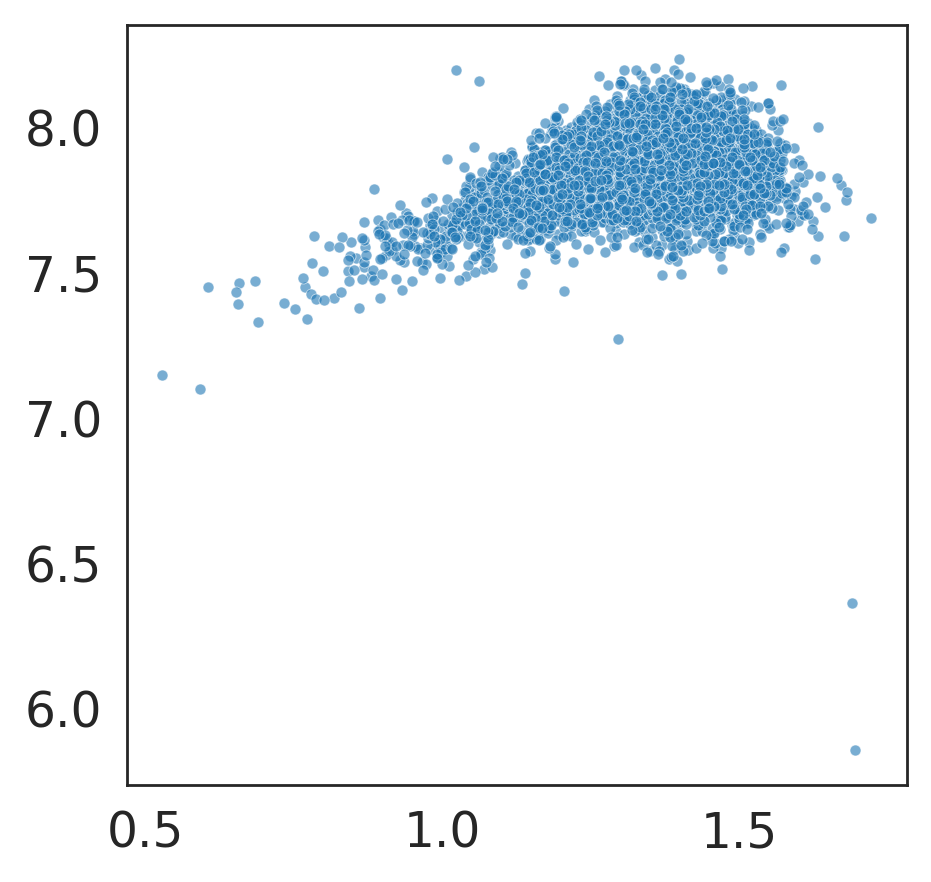

In [ ]:
sns.scatterplot(coord_trans[:,0],coord_trans[:,1],s=10,alpha=0.6)

In [ ]:

coord_trans2 = reducer.fit_transform(rand_coords)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


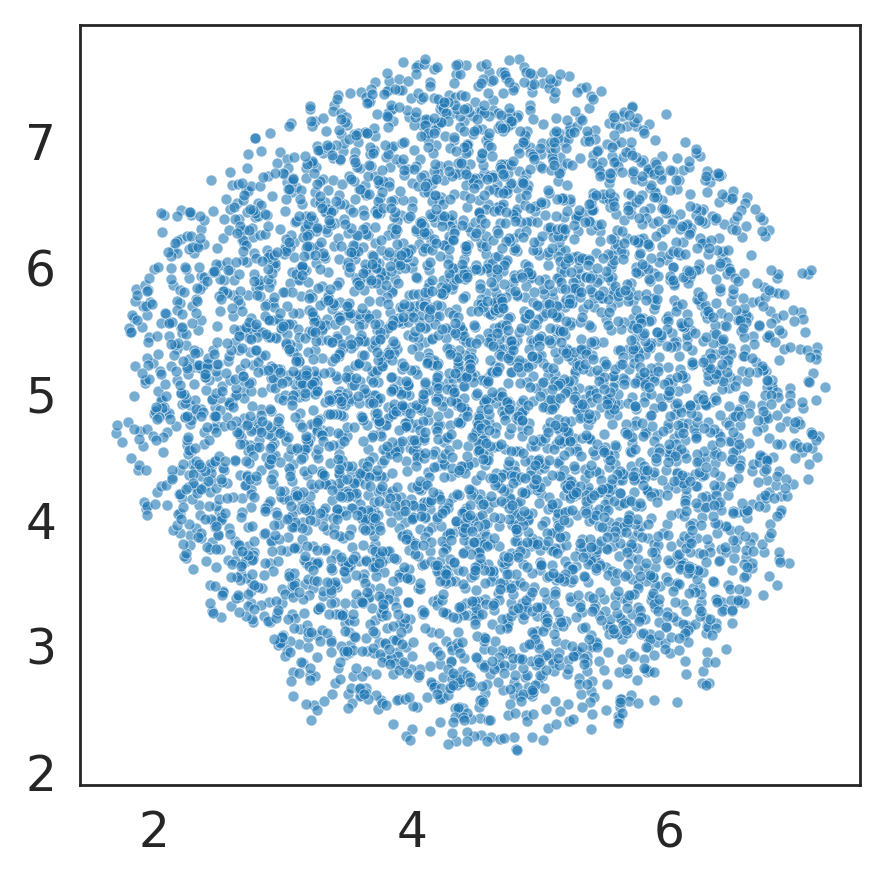

In [ ]:
sns.scatterplot(coord_trans2[:,0],coord_trans2[:,1],s=10,alpha=0.6)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


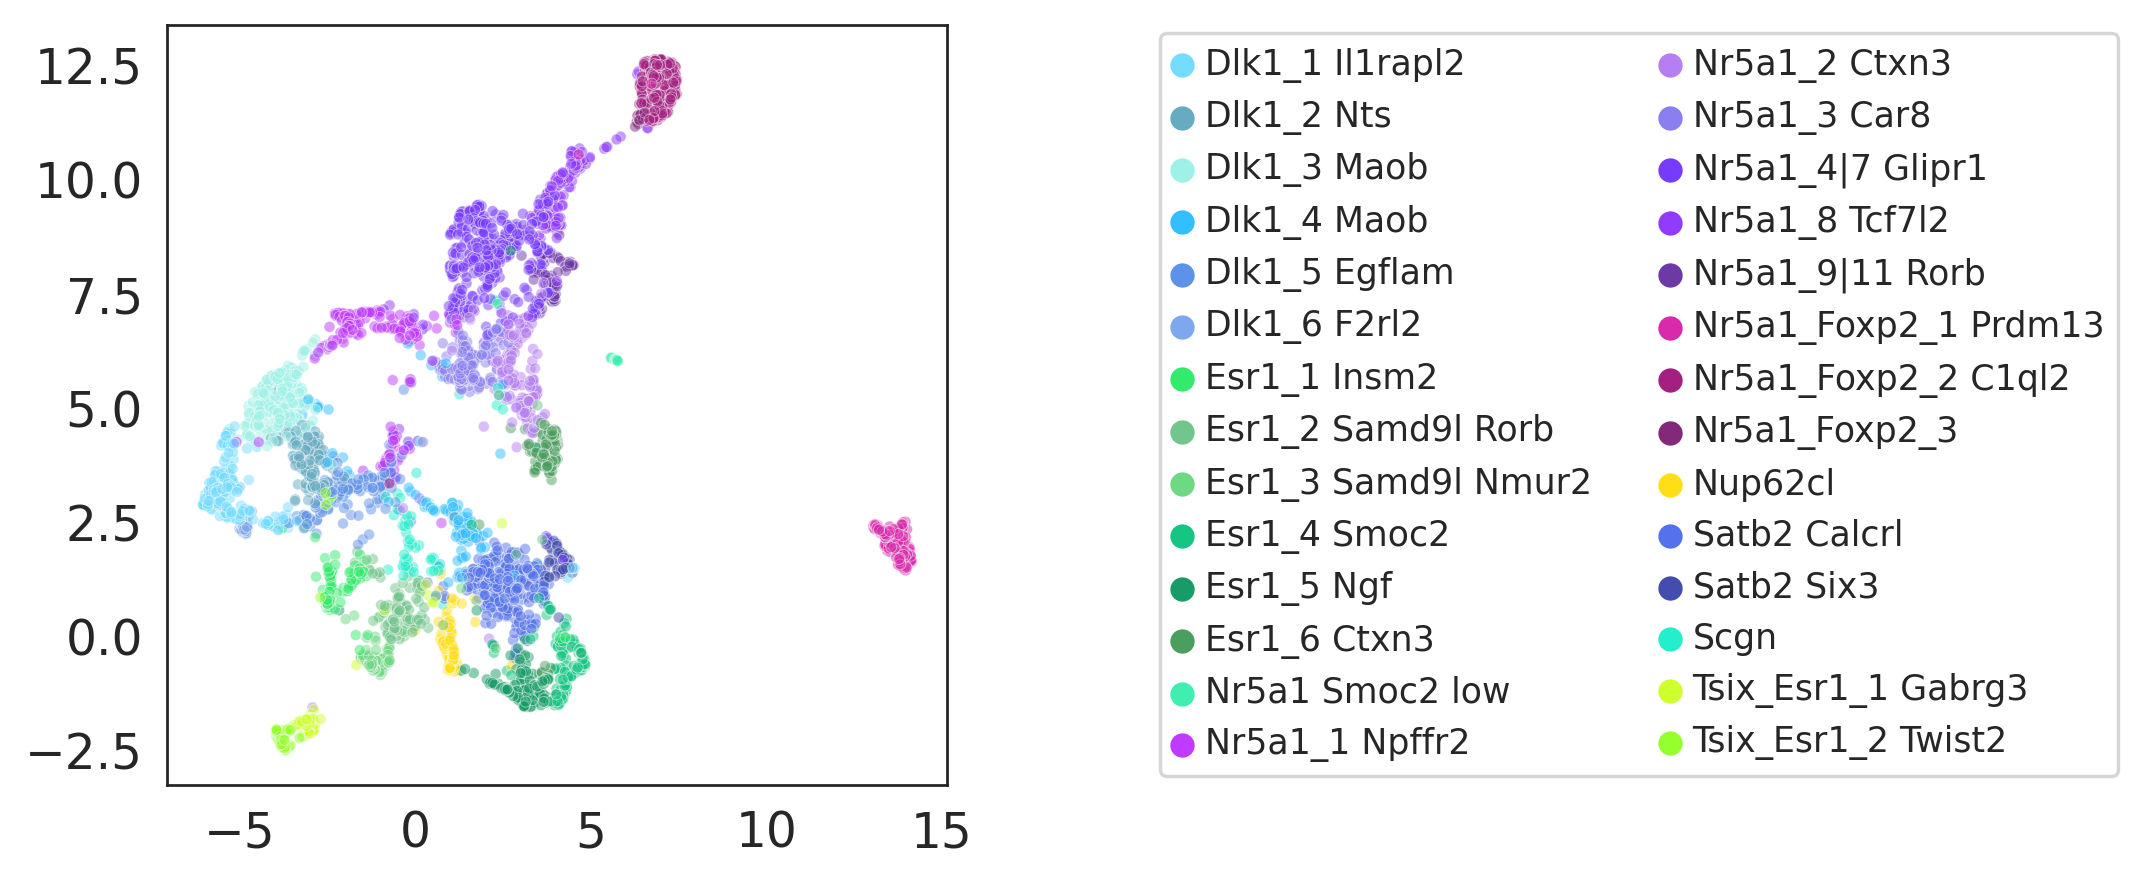

In [ ]:
#Data UMAP
cdict = {}
clus_list = pd.unique(meta.smartseq_cluster)
col_list = pd.unique(meta.smartseq_cluster_color)
for i in range(len(pd.unique(meta.smartseq_cluster))):
  cdict[clus_list[i]] = col_list[i]

g=sns.scatterplot(pcaUMAP[:,0],pcaUMAP[:,1],hue=pd.Categorical(lab1),palette = cdict, alpha=0.5,s=10)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2, fontsize=10)
plt.grid(False)